# Calc the tracer dependence of EIV and EEIV

In [1]:
clear
homedir = getenv('HOME');
workdir = getenv('WORK');
scradir = getenv('SCRATCH');
campdir = getenv('CAMP');
addpath(genpath([homedir '/work_MOM']));
addpath(genpath([homedir '/mytoolbox']));
addpath(genpath([homedir '/MyFuncs']));

In [2]:
%-------- read model grid
grid_dir = [workdir '/MOM6_exp/mom_lowRES/'];  
[grid, ~, ~] = read_grid_MOM([grid_dir '']); % SOLUTION/
klay = 1;

% ------- time
yr_s = 21;
[day_s, day_e, dt] = deal(31, 730, 30); 
t_al = day_s:dt:day_e;
nt_al = length(t_al);

%-------- dir 
tmStr = '_180d';
carries = [1:8 9 11];
% 
EEIV_dir = [workdir '/MOM6_OUT/tr_off_64' tmStr '/params/lmddotn_SIGNxmean_ka400_usesol_prog_addreld10/'];  
trac_comb_EEIV = nchoosek(carries,1);
ncomb_EEIV = size(trac_comb_EEIV,1);
% 
EIV_dir = [workdir '/MOM6_OUT/tr_off_64' tmStr '/params/lmd_ka400_usesol_prog_addreld10/'];  
trac_comb_EIV = nchoosek(carries,2);
% randomly choose
ncomb_choose = 10;
icomb_choose = sort( randperm(size(trac_comb_EIV,1), ncomb_choose) );
trac_comb_EIV = trac_comb_EIV(icomb_choose,:);
% 
ncomb_EIV = size(trac_comb_EIV,1);

In [3]:
EEIV_al = zeros(grid.nih,grid.njh,nt_al,ncomb_EEIV);
[EIV_u_al, EIV_v_al] = deal(zeros(grid.nih,grid.njh,nt_al,ncomb_EIV));

for icomb = 1:ncomb_EEIV
    read_dir = [EEIV_dir 'C' num2str(trac_comb_EEIV(icomb,:),'%02d') '/'];
    for it = 1:nt_al
        [yrstr, dystr, hrstr] = get_timestr(t_al(it), yr_s); 
        fnm = [read_dir 'K__' yrstr '_' dystr '_' hrstr '.nc'];
        ds = ncstruct(fnm);
        EEIV_al(:,:,it,icomb) = ds.chidotn(:,:,klay); 
    end % t
end % tr-set

for icomb = 1:ncomb_EIV
    read_dir = [EIV_dir 'C' num2str(trac_comb_EIV(icomb,:),'%02d') '/'];
    for it = 1:nt_al
        [yrstr, dystr, hrstr] = get_timestr(t_al(it), yr_s); 
        fnm = [read_dir 'K__' yrstr '_' dystr '_' hrstr '.nc'];
        ds = ncstruct(fnm);
        EIV_u_al(:,:,it,icomb) = ds.lmdu(:,:,klay); 
        EIV_v_al(:,:,it,icomb) = ds.lmdv(:,:,klay); 
    end % t
end % tr-set


% --- std/mean
dim = 4;
fluc_EEIV = std(EEIV_al, 1, dim, 'omitnan') ./ abs(nanmean(EEIV_al, dim));
fluc_EIVu = std(EIV_u_al, 1, dim, 'omitnan') ./ abs(nanmean(EIV_u_al, dim));
fluc_EIVv = std(EIV_v_al, 1, dim, 'omitnan') ./ abs(nanmean(EIV_v_al, dim));
fluc_EIV = (fluc_EIVu + fluc_EIVv) / 2;


In [4]:
% -- save data
savefnm = [homedir '/work_MOM/data_for_figure/data_fig6.mat'];
save(savefnm,'t_al','dt','EEIV_dir','EIV_dir','fluc_EEIV','fluc_EIVu','fluc_EIVv','fluc_EIV','trac_comb_EEIV','trac_comb_EIV');

## PLOT

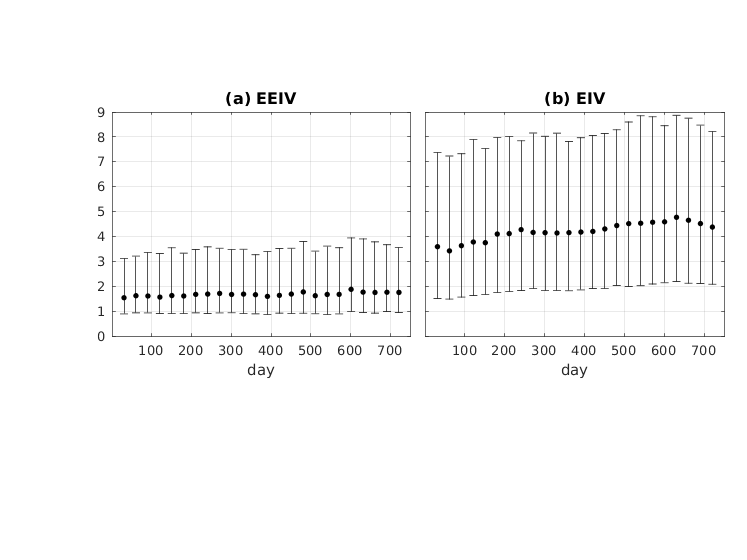

In [5]:

x_top = 0.15; y_top = 0.4; h_top = 0.4; w_top = 0.4; dx_top = 0.02;
pos_top = { [x_top y_top w_top h_top], [x_top+w_top+dx_top y_top w_top h_top] };

% ---- 
[err_m,err_med,err_h,err_l] = stats_ptc(fluc_EEIV, 75,25); 
% 
xlim = [t_al(1)-dt t_al(end)+dt]; ylim = [0 9]; dy = 1;
x = t_al;
y = err_med; [neg, pos] = deal(y - err_l, err_h - y);
% 
figure
subplot('Position',pos_top{1});
h = errorbar(x,y,neg,pos);
ax = gca;
% set properties of plot
h.Marker = '.';
h.Color = 'k';
h.MarkerSize = 12;
h.LineStyle = 'none';
ax.XLim = xlim;
ax.YLim = ylim;
ax.YTick = ylim(1):dy:ylim(2);
ax.XGrid = 'on'; ax.YGrid = 'on';
xlabel('day')
title(['(a) EEIV'],'fontsize',12)

% ---- 
[err_m,err_med,err_h,err_l] = stats_ptc(fluc_EIV, 75,25); 
% 
xlim = [t_al(1)-dt t_al(end)+dt]; ylim = [0 9]; dy = 1;
x = t_al;
y = err_med; [neg, pos] = deal(y - err_l, err_h - y);
% 
subplot('Position',pos_top{2});
h = errorbar(x,y,neg,pos);
ax = gca;
% set properties of plot
h.Marker = '.';
h.Color = 'k';
h.MarkerSize = 12;
h.LineStyle = 'none';
ax.XLim = xlim;
ax.YLim = ylim;
ax.YTick = ylim(1):dy:ylim(2);
ax.YTickLabel = '';
ax.XGrid = 'on'; ax.YGrid = 'on';
xlabel('day')
title(['(b) EIV'],'fontsize',12)

% ---
set(gcf,'PaperPositionMode','auto'); 
fignm = [homedir '/work_MOM/figures/fig_trdepend_EEIV_EIV'];
% exportgraphics(gcf,[fignm '.pdf'], 'BackgroundColor','white','ContentType','vector')
